In [12]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'

train_cleaned = pd.read_pickle(PATH + 'train_cleaned_bureau_final.pkl')
test_cleaned = pd.read_pickle(PATH + 'test_cleaned_bureau_final.pkl')
print('done')

done


In [13]:
from sklearn.preprocessing import LabelEncoder

categorical_feats = [
    'NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21','WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

for x in categorical_feats:
    if train_cleaned[x].dtype == 'object':
        print(x)
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)
        train_cleaned[x] = LabelEncoder().fit_transform(train_cleaned[x])
        test_cleaned[x] = LabelEncoder().fit_transform(test_cleaned[x])
    else:
        train_cleaned[x].fillna('na', inplace=True)
        test_cleaned[x].fillna('na', inplace=True)
print('done')

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
done


In [14]:
target = train_cleaned['TARGET']
ignore_cols = ['ORGANIZATION_TYPE', 'TARGET', 'SK_ID_CURR']
features = [x for x in train_cleaned.columns if x not in ignore_cols]
train = train_cleaned[features]
test = test_cleaned[features]

In [15]:
%%time

from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm

lgbm_train = lgbm.Dataset(data=train,
                          label=target,
                          
                          categorical_feature=categorical_feats,
                          free_raw_data=False)

lgbm_params = {'num_threads': 8, 'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}

cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     early_stopping_rounds=150,
                     verbose_eval=200,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)

""" Predict on test set and create submission """
y_pred = clf.predict(test)
out_df = pd.DataFrame({'SK_ID_CURR': test_cleaned['SK_ID_CURR'], 'TARGET': y_pred})
print('done')

/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's auc: 0.741857 + 0.00370355
[400]	cv_agg's auc: 0.753417 + 0.00360101
[600]	cv_agg's auc: 0.761891 + 0.00338887
[800]	cv_agg's auc: 0.76584 + 0.00296149
[1000]	cv_agg's auc: 0.767655 + 0.00263503
[1200]	cv_agg's auc: 0.768651 + 0.00251906
[1400]	cv_agg's auc: 0.769115 + 0.00248157
[1600]	cv_agg's auc: 0.769372 + 0.00243217
[1800]	cv_agg's auc: 0.769541 + 0.00245366
[2000]	cv_agg's auc: 0.769677 + 0.00246423
[2200]	cv_agg's auc: 0.769672 + 0.00250431
Optimum boost rounds = 2126
Best CV result = 0.7696966023091429
done
CPU times: user 3h 55min 59s, sys: 26.5 s, total: 3h 56min 26s
Wall time: 29min 37s


In [16]:
print((out_df['TARGET']>0.5).sum())

131


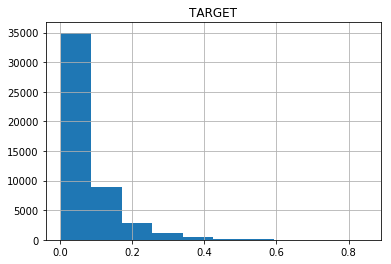

In [17]:
import matplotlib.pyplot as plt
out_df[['TARGET']].hist()
plt.show()

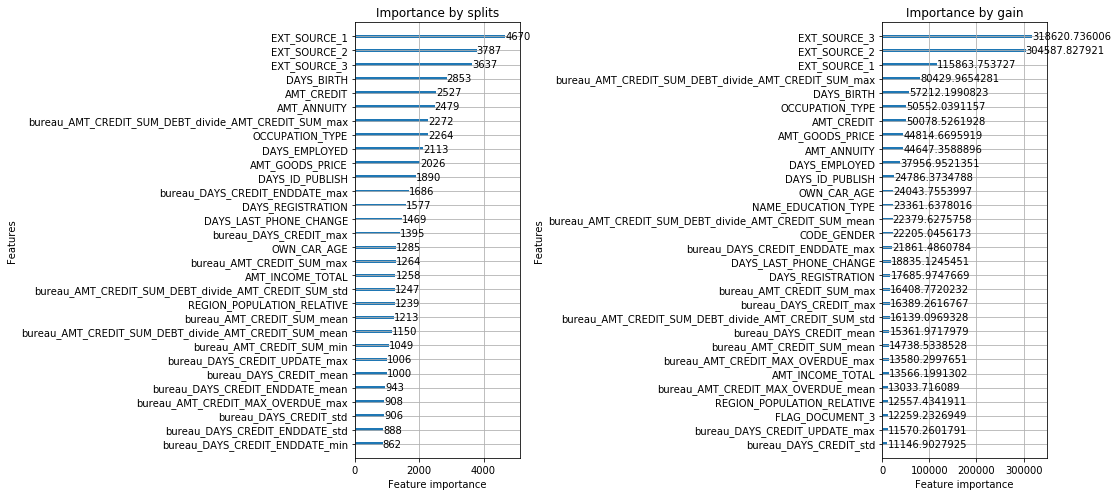

In [18]:
import matplotlib.pyplot as plt

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=30, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=30, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.show()

In [19]:
out_df.to_csv(PATH + 'submission_bureau_final.csv', index=False)
print('done')

done


In [20]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('gain'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
x

[(0, ('EXT_SOURCE_3', 318620.73600567877)),
 (1, ('EXT_SOURCE_2', 304587.82792088389)),
 (2, ('EXT_SOURCE_1', 115863.75372681022)),
 (3,
  ('bureau_AMT_CREDIT_SUM_DEBT_divide_AMT_CREDIT_SUM_max',
   80429.965428054333)),
 (4, ('DAYS_BIRTH', 57212.199082255363)),
 (5, ('OCCUPATION_TYPE', 50552.039115667343)),
 (6, ('AMT_CREDIT', 50078.526192784309)),
 (7, ('AMT_GOODS_PRICE', 44814.669591903687)),
 (8, ('AMT_ANNUITY', 44647.358889639378)),
 (9, ('DAYS_EMPLOYED', 37956.952135115862)),
 (10, ('DAYS_ID_PUBLISH', 24786.373478829861)),
 (11, ('OWN_CAR_AGE', 24043.755399748683)),
 (12, ('NAME_EDUCATION_TYPE', 23361.637801647186)),
 (13,
  ('bureau_AMT_CREDIT_SUM_DEBT_divide_AMT_CREDIT_SUM_mean',
   22379.627575844526)),
 (14, ('CODE_GENDER', 22205.045617341995)),
 (15, ('bureau_DAYS_CREDIT_ENDDATE_max', 21861.486078359187)),
 (16, ('DAYS_LAST_PHONE_CHANGE', 18835.124545102939)),
 (17, ('DAYS_REGISTRATION', 17685.974766880274)),
 (18, ('bureau_AMT_CREDIT_SUM_max', 16408.772023200989)),
 (19, ('

In [21]:
x = [x for x in zip(clf.feature_name(), clf.feature_importance('split'))]
x.sort(key=lambda x: x[1], reverse=True)
x = [(i, j) for i, j in enumerate(x)]
x

[(0, ('EXT_SOURCE_1', 4670)),
 (1, ('EXT_SOURCE_2', 3787)),
 (2, ('EXT_SOURCE_3', 3637)),
 (3, ('DAYS_BIRTH', 2853)),
 (4, ('AMT_CREDIT', 2527)),
 (5, ('AMT_ANNUITY', 2479)),
 (6, ('bureau_AMT_CREDIT_SUM_DEBT_divide_AMT_CREDIT_SUM_max', 2272)),
 (7, ('OCCUPATION_TYPE', 2264)),
 (8, ('DAYS_EMPLOYED', 2113)),
 (9, ('AMT_GOODS_PRICE', 2026)),
 (10, ('DAYS_ID_PUBLISH', 1890)),
 (11, ('bureau_DAYS_CREDIT_ENDDATE_max', 1686)),
 (12, ('DAYS_REGISTRATION', 1577)),
 (13, ('DAYS_LAST_PHONE_CHANGE', 1469)),
 (14, ('bureau_DAYS_CREDIT_max', 1395)),
 (15, ('OWN_CAR_AGE', 1285)),
 (16, ('bureau_AMT_CREDIT_SUM_max', 1264)),
 (17, ('AMT_INCOME_TOTAL', 1258)),
 (18, ('bureau_AMT_CREDIT_SUM_DEBT_divide_AMT_CREDIT_SUM_std', 1247)),
 (19, ('REGION_POPULATION_RELATIVE', 1239)),
 (20, ('bureau_AMT_CREDIT_SUM_mean', 1213)),
 (21, ('bureau_AMT_CREDIT_SUM_DEBT_divide_AMT_CREDIT_SUM_mean', 1150)),
 (22, ('bureau_AMT_CREDIT_SUM_min', 1049)),
 (23, ('bureau_DAYS_CREDIT_UPDATE_max', 1006)),
 (24, ('bureau_DAYS_CRE